In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [11]:
import pandas as pd
import cleaning_game_file as cgf
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import math

In [3]:
data = pd.read_csv('data/game_files.csv', sep=';', encoding="latin-1", low_memory = False)

df_obj = cgf.Cleaner(data)
df_obj.clean_data()

df = df_obj.data.copy()

## Goal for analysis

At this point, there are a fair number of columns to go through and analyze for the purpose of filling missing values. At this moment, I am looking to at least handle "estimated_ba_using_speedangle" (which is crucial for the next steps), "babip_value", and "bat_event". Hopefully, some of the other batting metics line up similarly to these stats and are easy to fill. The pitching stats might have to be handled while I look more in-depth into pitcher analysis. I will start with an overall analysis, to see how missing values line up, hoping to get further information on this, and in seeing if there is a pattern that emerges which contains information about the dataset. I will then look further into the areas I feel necessary to look into.

## Overall missing values

At this point, I have handled all columns that could be filled or corrected without further analysis. This includes pitcher and batter names, game_date correction, dropping deprecated and columns that will be unavailable/irrelevant, event separation and simplification, and simplification of baserunner data. I expect to remove baserunner data due to it being very at bat specific when the goal is to achieve a game-by-game prediction. Below, I have taken the remaining missing values and plotted their missing values against eachother.

In [24]:
cols = df.columns

missing_cols = []
not_missing_cols = []

for col in cols:
    if df[col].isna().sum() > 0:
        missing_cols.append(col)
    else:
        not_missing_cols.append(col)

<AxesSubplot:>

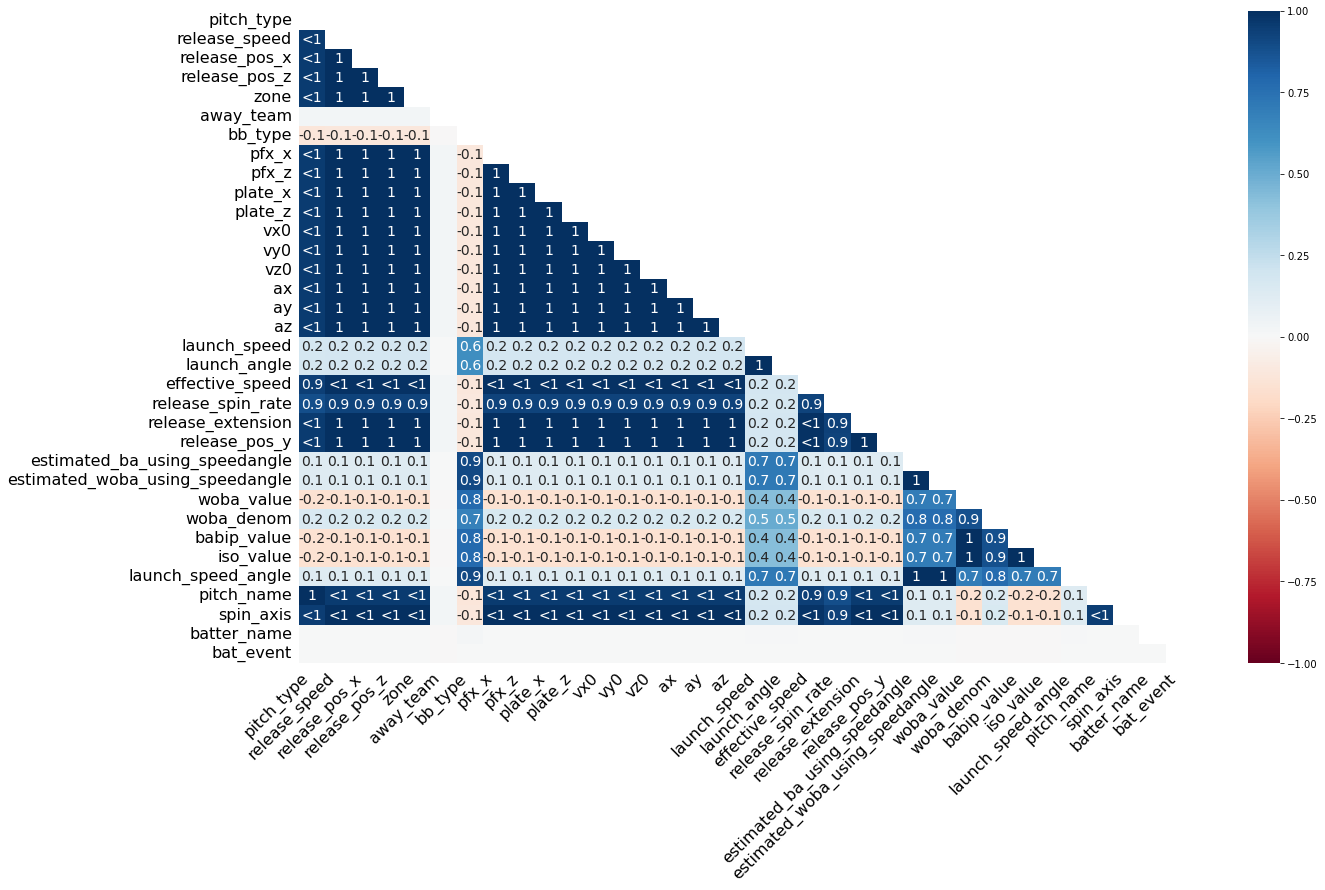

In [5]:
df_missing = df[missing_cols]

msno.heatmap(df_missing)

In [6]:
df_missing.isna().sum()

pitch_type                          283021
release_speed                       302991
release_pos_x                       303279
release_pos_z                       303279
zone                                303069
away_team                              457
bb_type                            2911260
pfx_x                               303070
pfx_z                               303069
plate_x                             303069
plate_z                             303069
sv_id                              3579204
vx0                                 303069
vy0                                 303069
vz0                                 303069
ax                                  303069
ay                                  303069
az                                  303069
launch_speed                       2627714
launch_angle                       2627783
effective_speed                     301476
release_spin_rate                   346374
release_extension                   304812
release_pos

There is a large amount of overlap in missing values for pitches, which leads to some questions in terms of events tied to these missing values. These could be values in which there was some play that did not involve a pitch being thrown such as a pickoff attempt or pitchout. Otherwise, these values might require more analysis for strictly pitching. On the other end, "batter_name" has no overlap, but I intend to use mlb.com/player and web scraping to handle those missing values.

"away_team" is a field I am surprised to see missing values for. I will have to look directly at these entries to see why these are missing. Perhaps it is a data entry error.

"estimated_ba_using_speedangle", "babip_value", and other hitting metrics should be able to be handled with further analysis. They appear to have little to no overlap with other missing values except for amongst themselves. While batting average on ball in play (babip) is an easily calculated metric, I hope to see some consistency in "estimated_ba_using_speedangle" and the others in terms of events and/or some other metric. Also, I expect alot of these missing metrics to be tied to pitches for which no ball was put into play.

In [26]:
miss_list = list(df_missing.isna().columns)
batdicts = []
bat_comp = []
pitchdicts = []
pitch_comp = []

miss_bat_list = ['estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'launch_speed', 'launch_angle', 'bb_type', 'sv_id']
miss_pitch_list = [x for x in miss_list if x not in miss_bat_list]
miss_pitch_list.remove('batter_name')
miss_pitch_list.remove('bat_event')
miss_pitch_list.remove('away_team')

for item in miss_bat_list:
    batdicts.append(df[df[item].isna()]['bat_event'].value_counts())
    
for item in miss_pitch_list:
    pitchdicts.append(df[df[item].isna()]['bat_event'].value_counts())
    
for item in miss_bat_list:
    bat_comp.append(df[item].isna().sum() - df[df[item].isna()][miss_bat_list].isna().sum())
    
for item in miss_pitch_list:
    pitch_comp.append(df[item].isna().sum() - df[df[item].isna()][miss_pitch_list].isna().sum())

ValueError: list.remove(x): x not in list

## Comparing Missing Hit Metrics

#### Event Correlation

In [8]:
miss_bat = pd.DataFrame(batdicts).fillna(0).astype("int")
miss_bat.index = miss_bat_list

miss_bat

,ball,strike,foul,strikeout,free_base,field_out,hit,error,runner_out,stolen_base
estimated_ba_using_speedangle,1177160,807899,608501,223315,92787,68720,35818,1921,1548,11
estimated_woba_using_speedangle,1177160,807899,608501,223315,92787,68720,35818,1921,1548,11
woba_value,1177127,807898,608501,0,0,0,0,0,0,0
woba_denom,1177132,807899,608501,37663,16839,77609,40380,2102,396,3
babip_value,1177127,807898,608501,0,0,0,0,0,0,0
iso_value,1177127,807898,608501,0,0,0,0,0,0,0
launch_speed_angle,1177160,807899,608501,223315,92787,68720,35818,1921,1548,11
launch_speed,1177160,807899,218656,223315,92722,68656,35806,1920,1546,11
launch_angle,1177160,807899,218654,223315,92722,68718,35814,1921,1546,11
bb_type,1177160,807899,608501,223315,92782,19,1,0,1548,11


#### Difference in Missing Values

In [9]:
miss_bat_comp = pd.DataFrame(bat_comp).fillna(0).astype("int")
miss_bat_comp.index = miss_bat_list

miss_bat_comp

,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,launch_speed,launch_angle,bb_type,sv_id
estimated_ba_using_speedangle,0,0,424167,262795,424167,424167,0,389993,389924,106448,0
estimated_woba_using_speedangle,0,0,424167,262795,424167,424167,0,389993,389924,106448,0
woba_value,0,0,0,0,0,0,0,389845,389847,0,0
woba_denom,13632,13632,175004,0,175004,175004,13632,403557,403488,120075,0
babip_value,0,0,0,0,0,0,0,389845,389847,0,0
iso_value,0,0,0,0,0,0,0,389845,389847,0,0
launch_speed_angle,0,0,424167,262795,424167,424167,0,389993,389924,106448,0
launch_speed,2,2,424021,262729,424021,424021,2,0,7,106365,0
launch_angle,2,2,424092,262729,424092,424092,2,76,0,106436,0
bb_type,3,3,317722,262793,317722,317722,3,389911,389913,0,0


Observing these values point to a a common theme in the missing values. The missing values were expected for the events of 'ball', 'strike', 'foul', 'strikeout', 'free base', 'stolen_base', and 'runner_out'. For the 'woba_denom', I am surprised to see so many missing values. I expected there to be some in these categories, but by factoring in how at-bats are incorporated into the wOBA denominator, there should be more of these values listed as non-null. However, some of the 'bb_type' descrepencies can be reconciled with keeping in mind that the 'free_base' category contains catcher interference. The 'field_out' and 'hit' values, deserve a look.

At this point, I will be looking into 'estimated_ba_using_sppedangle', 'estimated_woba_using_speedangle', 'woba_denom', 'launch_speed_angle', and 'bb_type'. 'sv_id' is listed as an unique key for events, but I will be removing this column from the final build. This is due to the large amount of missing values and irrelevance to the outcome. 'launch_speed' and 'launch_angle' could use further investigation into its usefulness.

## Comparing Missing Pitch Metrics

#### Event Correlation

In [10]:
miss_pitch = pd.DataFrame(pitchdicts).fillna(0).astype("int")
miss_pitch.index = miss_pitch_list

miss_pitch

,strike,field_out,ball,hit,strikeout,free_base,foul,error,runner_out,stolen_base
pitch_type,66619,62571,57443,33597,32382,14506,13705,1824,355,2
release_speed,71157,64871,64381,34821,33505,15003,16990,1882,362,2
release_pos_x,71222,64908,64483,34833,33524,15009,17037,1882,362,2
release_pos_z,71222,64908,64483,34833,33524,15009,17037,1882,362,2
zone,71178,64880,64415,34826,33508,15003,16996,1882,362,2
pfx_x,71178,64880,64415,34826,33508,15004,16996,1882,362,2
pfx_z,71178,64880,64415,34826,33508,15003,16996,1882,362,2
plate_x,71178,64880,64415,34826,33508,15003,16996,1882,362,2
plate_z,71178,64880,64415,34826,33508,15003,16996,1882,362,2
vx0,71178,64880,64415,34826,33508,15003,16996,1882,362,2


#### Difference in Missing Values

In [11]:
miss_pitch_comp = pd.DataFrame(pitch_comp).fillna(0).astype("int")
miss_pitch_comp.index = miss_pitch_list

miss_pitch_comp

,pitch_type,release_speed,release_pos_x,release_pos_z,zone,pfx_x,pfx_z,plate_x,plate_z,vx0,...,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,release_pos_y,pitch_name,spin_axis
pitch_type,0,1499,1415,1415,1415,1415,1415,1415,1415,1415,...,1415,1415,1415,1415,5772,1374,1424,1415,0,1415
release_speed,21469,0,6,6,6,6,6,6,6,6,...,6,6,6,6,4383,0,0,6,21469,6
release_pos_x,21673,294,0,0,210,210,210,210,210,210,...,210,210,210,210,4467,9,9,0,21673,0
release_pos_z,21673,294,0,0,210,210,210,210,210,210,...,210,210,210,210,4467,9,9,0,21673,0
zone,21463,84,0,0,0,0,0,0,0,0,...,0,0,0,0,4467,9,9,0,21463,0
pfx_x,21464,85,1,1,1,0,1,1,1,1,...,1,1,1,1,4468,10,10,1,21464,1
pfx_z,21463,84,0,0,0,0,0,0,0,0,...,0,0,0,0,4467,9,9,0,21463,0
plate_x,21463,84,0,0,0,0,0,0,0,0,...,0,0,0,0,4467,9,9,0,21463,0
plate_z,21463,84,0,0,0,0,0,0,0,0,...,0,0,0,0,4467,9,9,0,21463,0
vx0,21463,84,0,0,0,0,0,0,0,0,...,0,0,0,0,4467,9,9,0,21463,0


This is more than a little intimidating to look at. While there are a plethora of these values (related to ball measurements at various completion of its movement to the plate) which share the same missing value numbers, the remaining categories are missing a similar number of values even though they tend to not be the same. This causes numerous problems, such as how to fill these values and how to handle these values in a producitonized environment, where the same ability to compare pitches to others in that pitcher's repertoire is less available. Each category might need its own model or method to fill, which is concerning. At the same time, my best solution is to resort to clustering methods, and filling in missing pitches with an expected metric.

There are approximately 3579177 pitches thrown over the accessed time for the data. While the number of pitches missing data might be small comparatively, this could make a huge impact on individual pitcher analysis. This can impact pitcher clustering, modeling matchup performance, and detecting changes in pitcher repertoire which could show up in recent performance. I will more than likely place a minimum on pitches thrown for the clustering that I will perform, but this is still a concerning issue that will need to be addressed. For now, I will focus on filling missing hitting metrics.

There also appears to be no correlation with batting events.

In [12]:
miss_bat_list.remove('sv_id')

## Analysing Missing Hitting Metrics

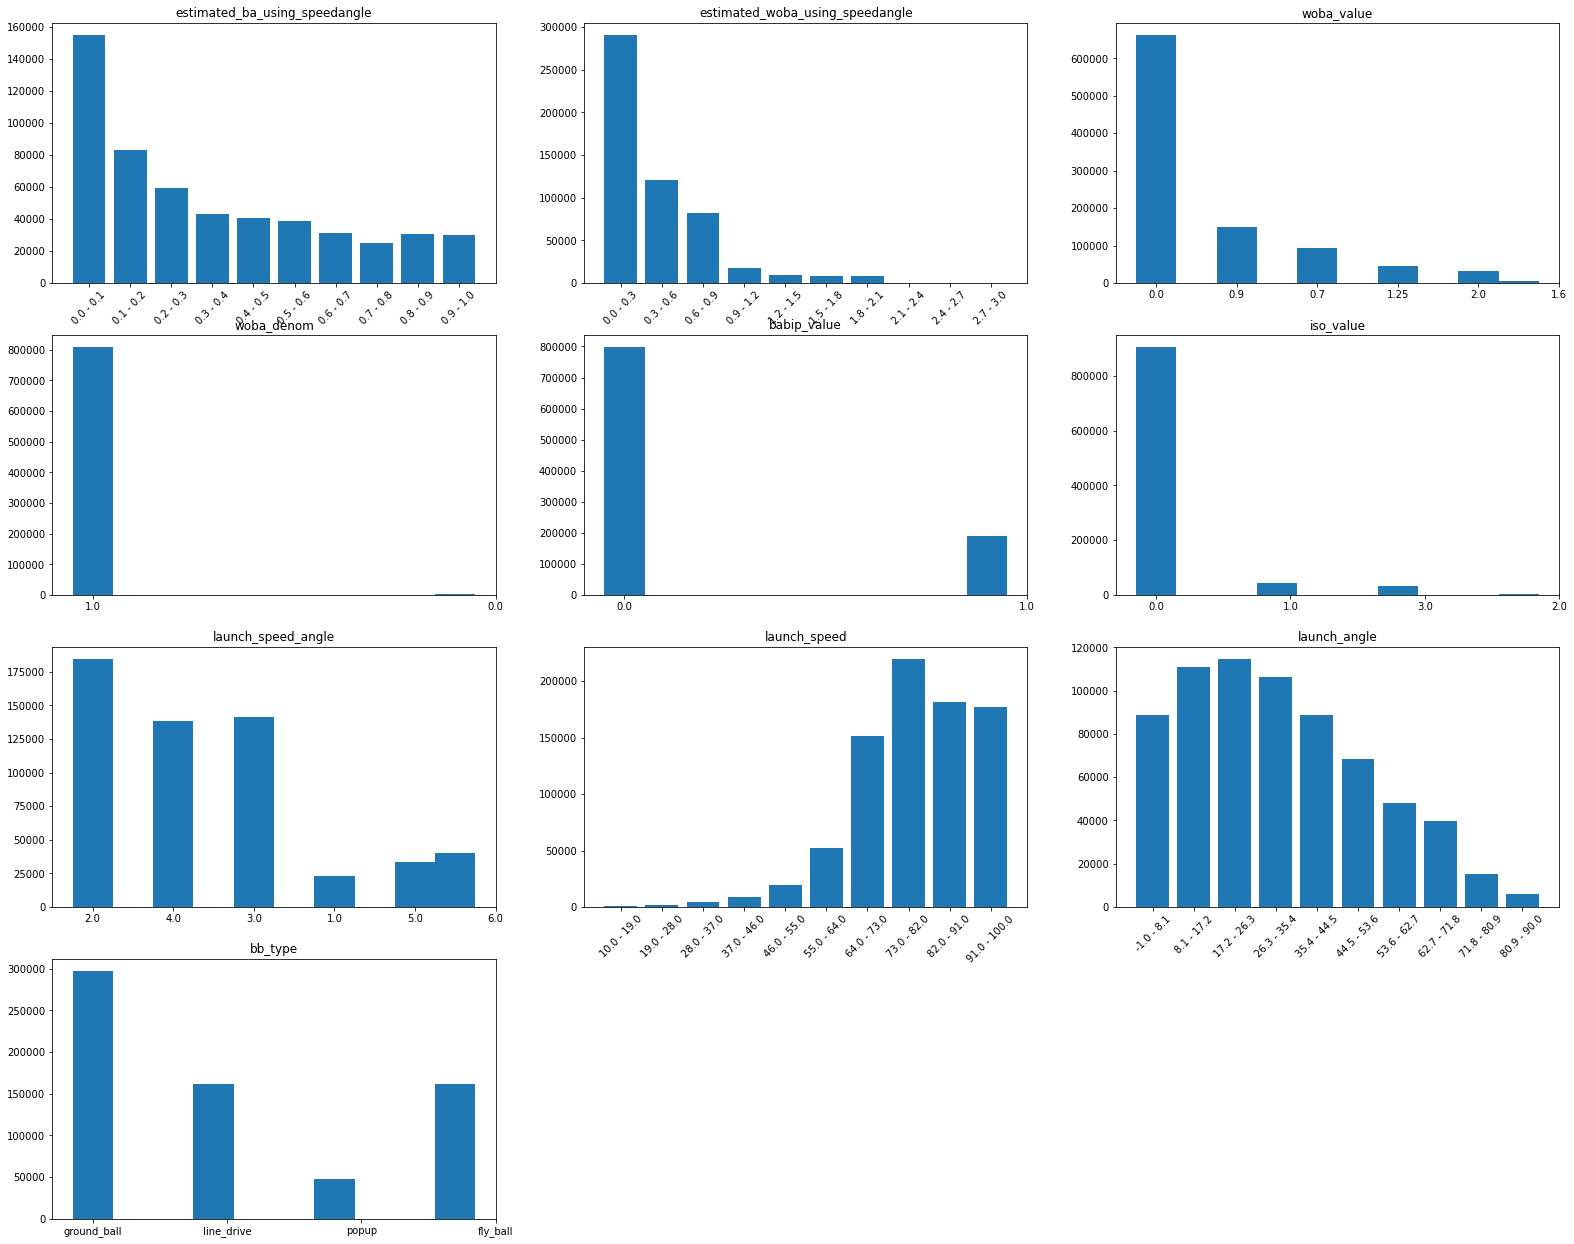

In [13]:
import math

df = df_obj.data

fig = plt.figure(figsize=(27, 22))
i = 1

for item in miss_bat_list:    
    ax=fig.add_subplot(4,3,i)
    plt.subplot(4, 3, i)
    
    df_temp = df[df[item].notna()][item]
    plt.title(item)
    
    if df[item].nunique() > 20:
        df_temp.astype('float')
        bin_num = 10
        item_max = math.ceil(float(df_temp.max()))
        item_min = math.floor(float(df_temp.min()))
        binwidth = (item_max - item_min) / bin_num
        bin_range = [float(round((item_min + (i * binwidth)), 2)) for i in range(0,bin_num+1)]
        
        temp_df = pd.cut(df[df[item].notna()][item].astype('float'), bin_range)
        bin_count = temp_df.value_counts()
        bins = [(str(bin_range[i]) + " - " + str(bin_range[i+1])) for i in range(0,len(bin_range)-1)]
        
        values = []
        for binned in list(bin_count.sort_index().index):
            val = int(bin_count[binned])
            values.append(val)
            
        plt.bar(bins, values)
        plt.xticks(rotation = 45)
    else:
        plt.hist(df_temp.sort_index(), align='left')
        
    plt.margins(0.05)
    
    i += 1

This metric uses the launch angle and launch speed of a hit ball and calculates the expected hit percentage based off this metric. Looking at the graph above for all known values, we can see a heavy bias towards zero. There is a decrease in values towards the top before a minor increase in amount of balls in play with higher likelihod of a hit. The same can be seen in other hit values measuring hit likelihood. However, launch speed and launch angle have a mode that is not on the edge, following a skewed bell curve. I expect similar approaches to be taken to similar categories.

I can take a similar approaches to 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', and 'woba_value'. These will be compared to statistics on event type and year of play. wOBA values are given based on averages for that year of play. For use in models, this will have to be normalized.

'woba_denom' will be filled based upon the play event. This is a designed value as part of the metric. The same will be done for 'babip_value' and 'iso_value'. 'launch_speed_angle' (categorical), 'launch_speed' (numerical), 'launch_angle' (numerical) are all tied to one another and are represented in 'estimated_ba_using_speedangle' and 'estimated_woba_using_speedangle'. This makes these stats redundant, and possibly more difficult to fill due to overlap in missing metrics. Therefore, these columns will be dropped in favor of other metrics.

'bb_type can be found tied to event, and has few, meaningful missing values. This makes it simple to fill and worth keeping just in case. I expect to drop this feature variable.

## Investigating Game Type

One explanation for the large number of missing statcast related values could be the access to publicly available metrics being diminished in teh spring training and exhiibition games which are included in the experiment. As such, I will try restricting the sum of missing entries to just regular season games. This could solve much of the issues in missing data. This could also prove to be a slightly more focused project, to test the viability of performing further reaching models.

In [14]:
sum_reg = df[df.game_type == 'R'].isna().sum()

for item in list(sum_reg.index):
    if sum_reg[item] > 0:
        miss_diff = df[df.game_type != "R"].isna().sum()[item] 
        print(item + ": " + str(sum_reg[item]) + " (" + str(miss_diff) + ")")

pitch_type: 12730 (270291)
release_speed: 13553 (289438)
release_pos_x: 13827 (289452)
release_pos_z: 13827 (289452)
zone: 13617 (289452)
bb_type: 2603074 (308186)
pfx_x: 13618 (289452)
pfx_z: 13617 (289452)
plate_x: 13617 (289452)
plate_z: 13617 (289452)
sv_id: 3148342 (430862)
vx0: 13617 (289452)
vy0: 13617 (289452)
vz0: 13617 (289452)
ax: 13617 (289452)
ay: 13617 (289452)
az: 13617 (289452)
launch_speed: 2236800 (390914)
launch_angle: 2236870 (390913)
effective_speed: 12042 (289434)
release_spin_rate: 55278 (291096)
release_extension: 15056 (289756)
release_pos_y: 13827 (289452)
estimated_ba_using_speedangle: 2610052 (407653)
estimated_woba_using_speedangle: 2610052 (407653)
woba_value: 2345510 (248028)
woba_denom: 2352493 (416049)
babip_value: 2345510 (248028)
iso_value: 2345510 (248028)
launch_speed_angle: 2610052 (407653)
pitch_name: 12730 (270291)
spin_axis: 17514 (289716)
batter_name: 3597 (558)
bat_event: 10 (17)


The absence of exhibition games, spring traing games, and postseason games removed the vast majority of missing values. The values in parentheses above are the removed missing values, despite removing less than a quarter of the games from the database. Due to this, I will focus this experiment on just regular season games.

In [8]:
df.drop(df[df.game_type != 'R'].index, inplace=True)

In [5]:
def separate_date(date, time_cat):
    if time_cat.lower() == 'year':
        return date.year
    if time_cat.lower() == 'month':
        return date.month
    if time_cat.lower() == 'day':
        return date.day

In [6]:
def binned_plot(df_temp, item, bin_num = 10):
    item_max = math.ceil(float(df_temp[item].max()))
    item_min = math.floor(float(df_temp[item].min()))
    binwidth = (item_max - item_min) / bin_num
    bin_range = [float(round((item_min + (i * binwidth)), 2)) for i in range(0,bin_num+1)]
    
    temp_df = pd.cut(df_temp[item].astype('float'), bin_range)
    bin_count = temp_df.value_counts()
    bins = [str(bin_range[i+1]) for i in range(0,len(bin_range)-1)]
    
    values = []
    for binned in list(bin_count.sort_index().index):
        val = int(bin_count[binned])
        values.append(val)
        
    plt.bar(bins, values, align='edge', width=-0.8)
    plt.xticks(rotation = 45)

In [7]:
def plot_against_event(df_temp, category, year='ALL'):
    if year != 'ALL':
        df_temp = df_temp[df_temp[category].notna()].copy()
        df_temp['game_year'] = df_temp['game_date'].apply(lambda x: separate_date(x, 'year'))
        df_temp.drop(df_temp[df_temp.game_year != year].index, inplace = True)
    else:
        df_temp = df_temp[df_temp[category].notna()]
        
    plt.figure(figsize=(25,25))
    event_expected = list(df_temp['events'].unique())
    
    for i in range(0,len(event_expected)):
        plt.subplot(5,5,i+1)
        
        binned_plot(df_temp[df_temp.events == event_expected[i]], category)
        
        plt.title(event_expected[i] + " - " + str(year))
        
    plt.show()
    return event_expected

#### Estimated Batting Average Using Speedangle

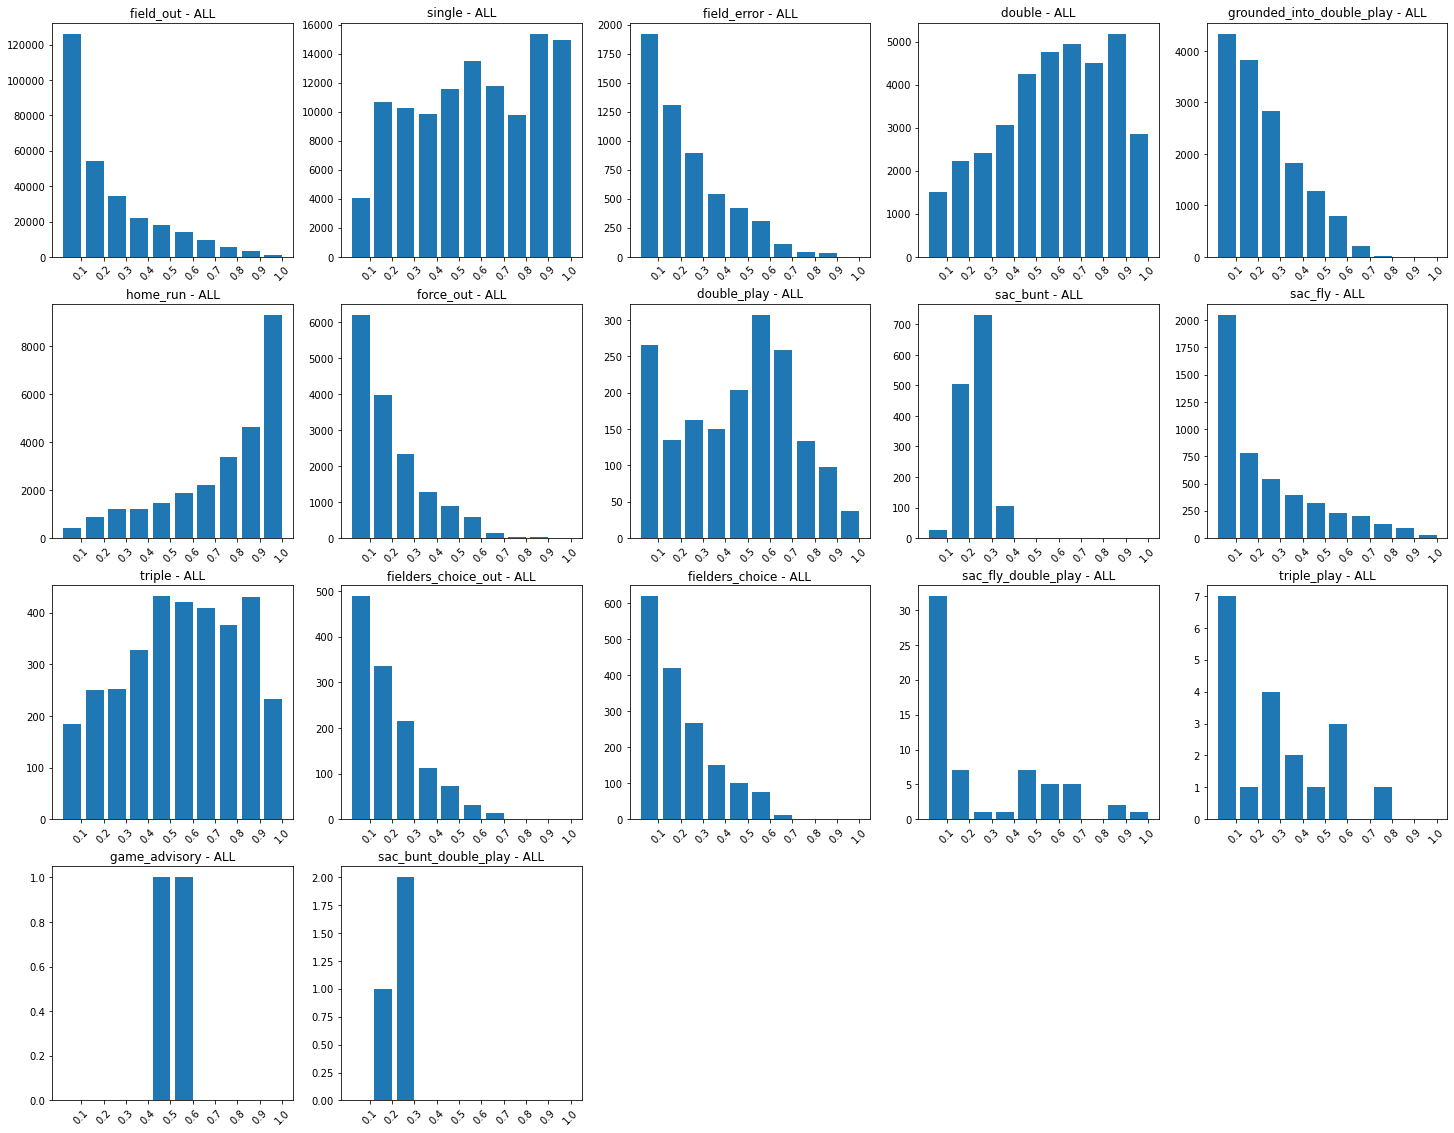

In [19]:
columns_fill = plot_against_event(df, 'estimated_ba_using_speedangle')

There are quite a few of these which follow a visual normal distribution. For the majority of events, a median is the best choice. This is the safest bet for filling the variable. However, I will revisit 'single', 'double', 'double_play', 'triple', and 'triple_play'.

In [20]:
columns_non_med = ['single', 'double', 'double_play', 'triple', 'triple_play']
columns_med = columns_fill

for item in columns_non_med:
    columns_med.remove(item)

In [4]:
def create_median_table(df_temp, category, events_list):
    median_table = {}
    temp_df = df_temp[df_temp[category].notnull()]
    
    for event in events_list:
        median_val = np.median(temp_df[temp_df.events == event][category].astype(float))
        median_table[event] = median_val
    
    return median_table

def replace_median(df_temp, category, events_list, years=None):        
    
    def handle_median(event, default):
        if event in events_list and pd.isnull(default):
            med_val = median_table[event]
            return med_val.astype(float)
        else:
            return float(default)
    
    if years == None:
        df_temp[category].astype('float')
        median_table = create_median_table(df_temp, category, events_list)
        df_temp[category] = df_temp.apply(lambda x: handle_median(x.events, x.estimated_ba_using_speedangle), axis=1)
    else:
        df_temp[category].astype('float')
        for year in years:
            mask = df_temp[df_temp.game_year == year]
            
            median_table = create_median_table(df_temp[df_temp.game_year == year], category, events_list)
            df_temp[df_temp.game_year == year][category] = df_temp[df_temp.game_year == year].apply(lambda x: handle_median(x.events, x.estimated_ba_using_speedangle), axis=1)

In [22]:
replace_median(df, 'estimated_ba_using_speedangle', columns_med)

In [23]:
for event in columns_non_med:
    var_test = df[df.events == event].isna().sum()['estimated_ba_using_speedangle']
    print(event + ": " + str(var_test))

single: 1412
double: 201
double_play: 17
triple: 22
triple_play: 0


In [39]:
df[df.events == 'field_error'].isna().sum()['estimated_woba_using_speedangle']

51

#### Estimated wOBA using Speed Angle

For this category, because wOBA is an average value for the year, we will fill the values also based upon the year. In the graphs below, we see that there are largely favored variables based on year and event type. wOBA will follow a similar purpose, as will iso.

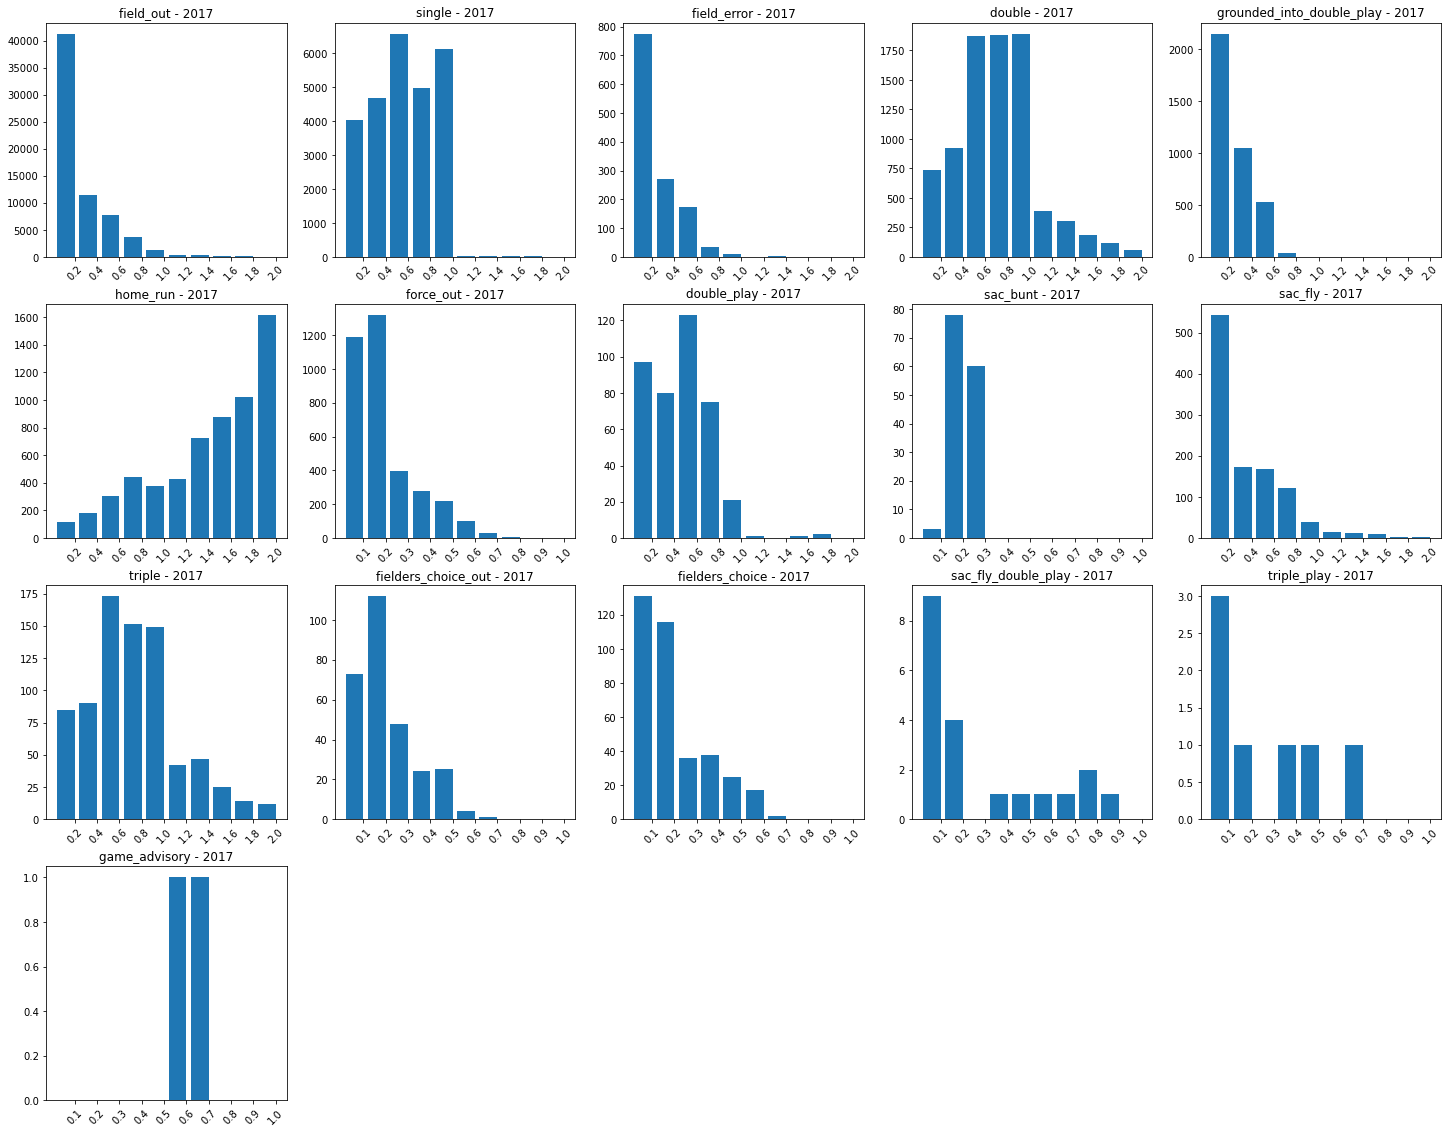

In [24]:
events = plot_against_event(df, 'estimated_woba_using_speedangle', year=2017)

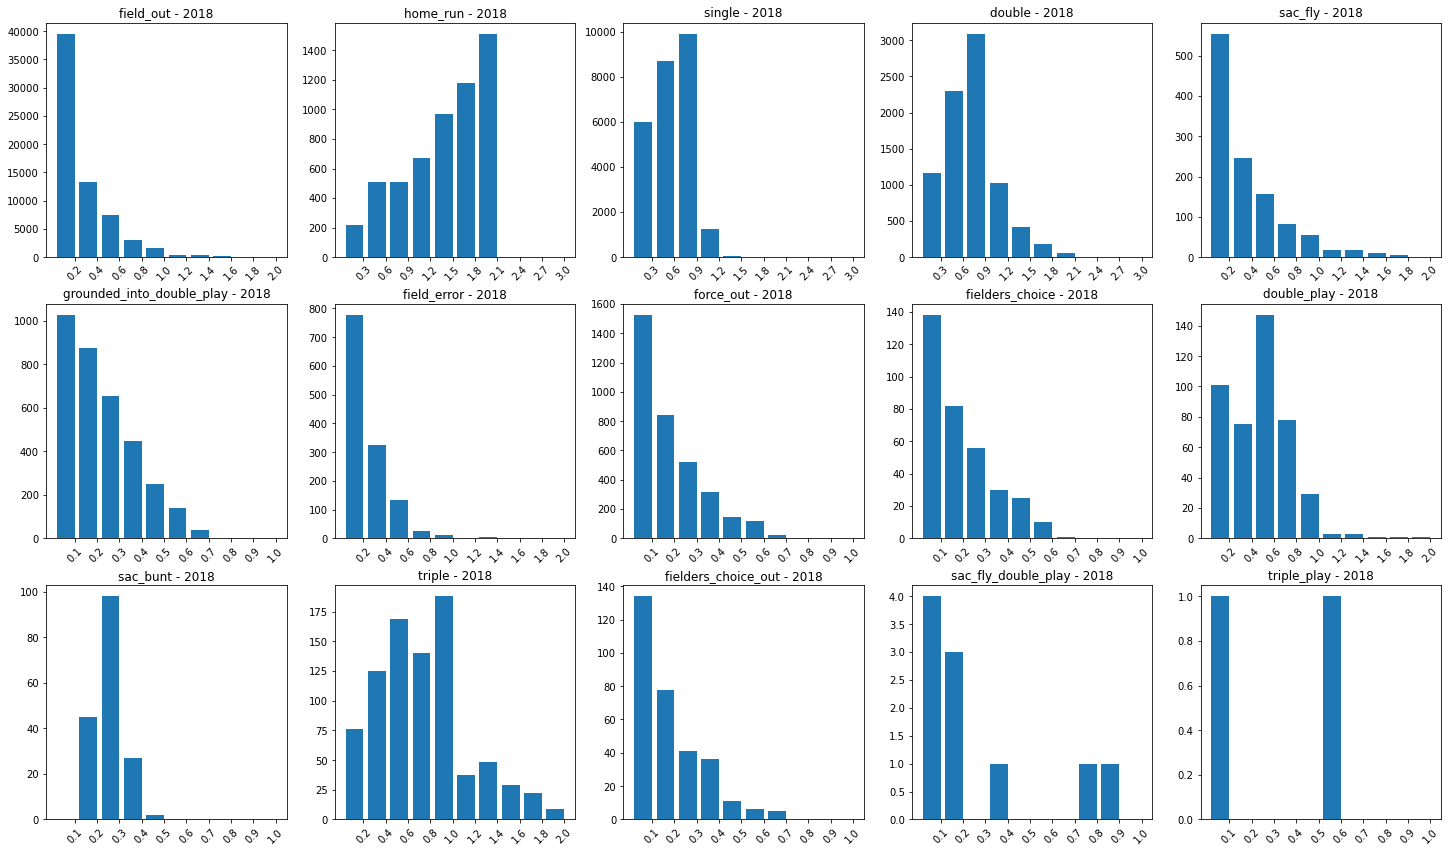

In [25]:
events = plot_against_event(df, 'estimated_woba_using_speedangle', year=2018)

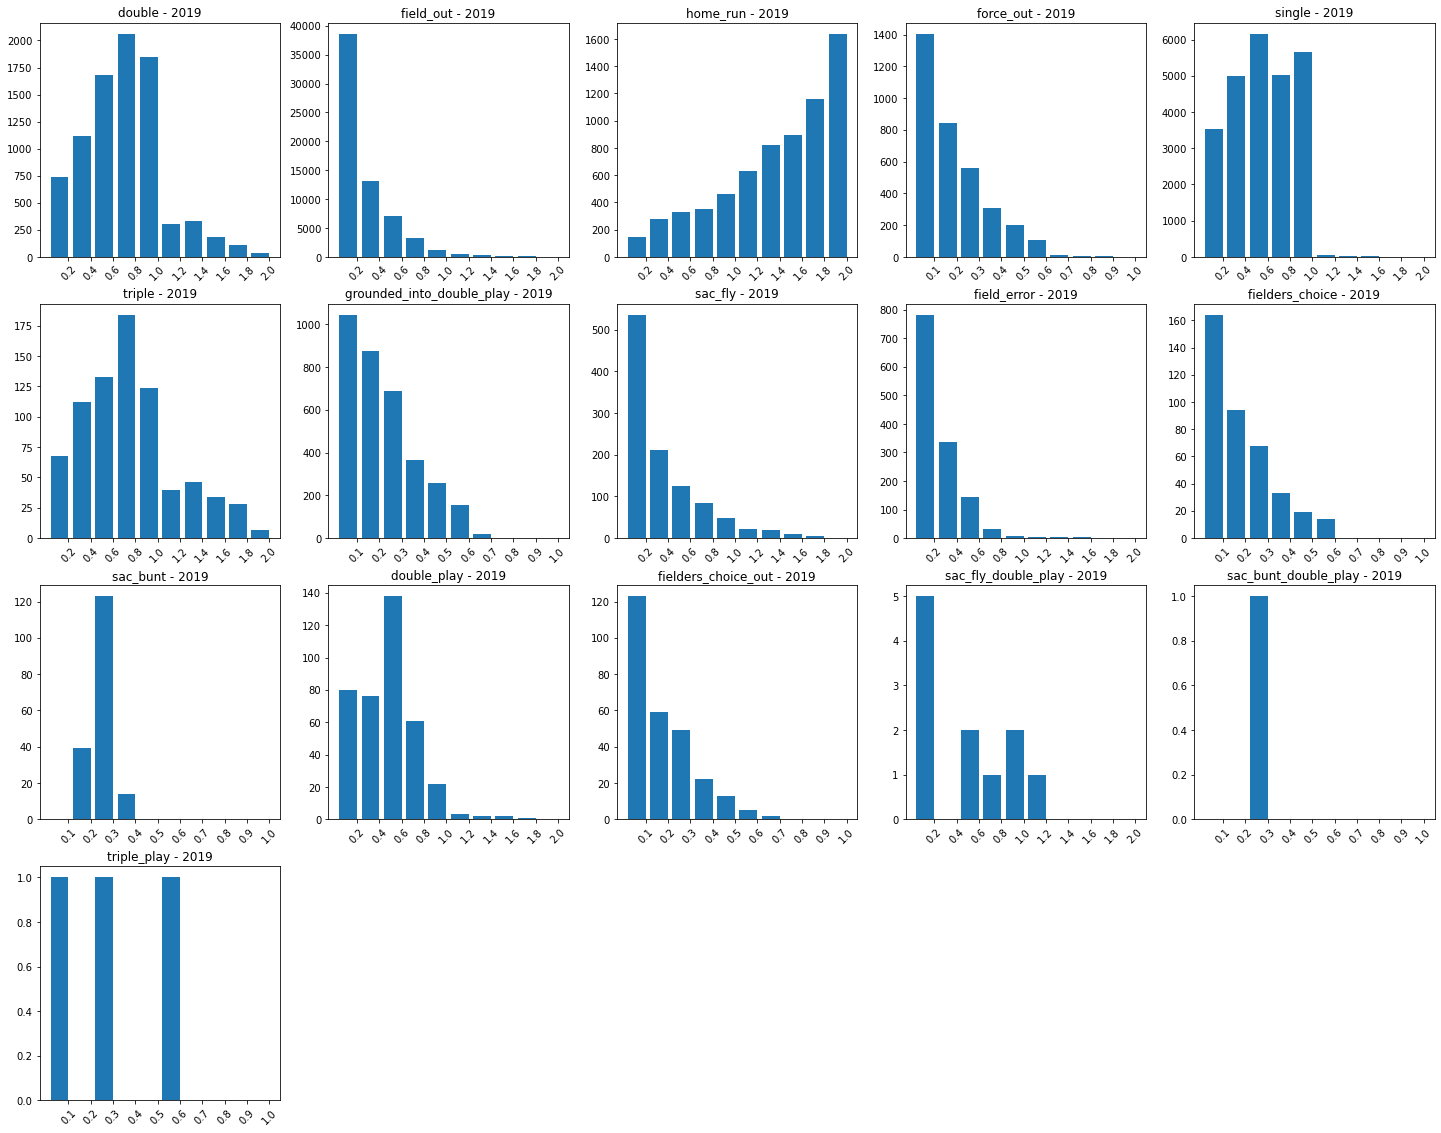

In [26]:
events = plot_against_event(df, 'estimated_woba_using_speedangle', year=2019)

In [27]:
def years_to_list(df_temp):
    df_temp['game_year'] = df_temp['game_date'].apply(lambda x: separate_date(x, 'year'))
    years_list = list(df_temp['game_year'].unique())

    #df_temp.drop('game_year', axis=1, inplace = True)
    
    return years_list

In [28]:
year_list = years_to_list(df)

replace_median(df, 'estimated_woba_using_speedangle', columns_fill, years=year_list)
replace_median(df, 'woba_value', columns_fill, years=year_list)

replace_median(df, 'woba_denom', columns_fill)
replace_median(df, 'babip_value', columns_fill)
replace_median(df, 'iso_value', columns_fill)

D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Python\Anaconda3_2020.11\envs\env\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
cols = df.columns

missing_cols = []
not_missing_cols = []

for col in cols:
    if df[col].isna().sum() > 0:
        missing_cols.append(col)
    else:
        not_missing_cols.append(col)

<AxesSubplot:>

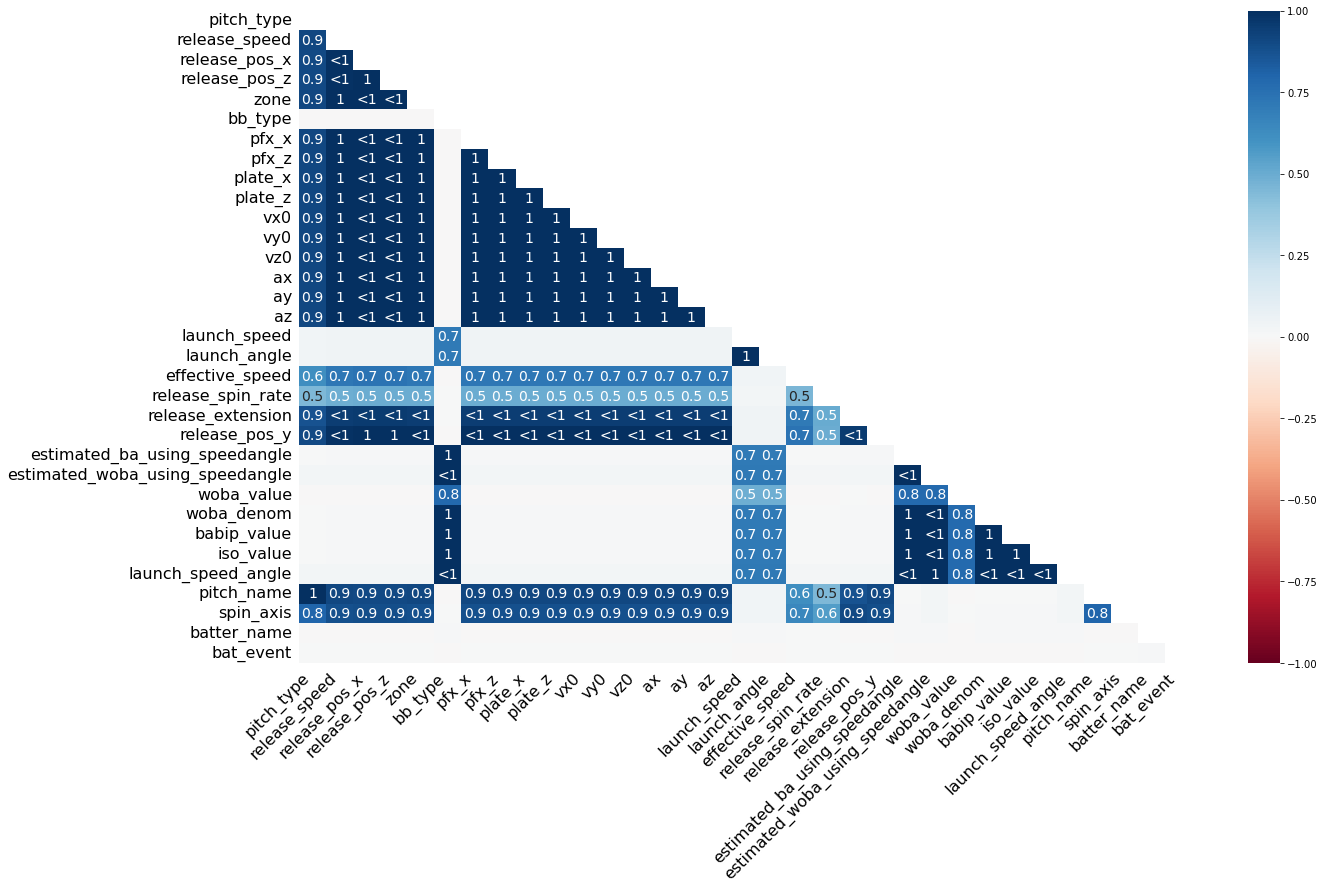

In [30]:
df_missing = df[missing_cols]

msno.heatmap(df_missing)

In [31]:
df_missing.isna().sum()

pitch_type                           12730
release_speed                        13553
release_pos_x                        13827
release_pos_z                        13827
zone                                 13617
bb_type                            2603074
pfx_x                                13618
pfx_z                                13617
plate_x                              13617
plate_z                              13617
sv_id                              3148342
vx0                                  13617
vy0                                  13617
vz0                                  13617
ax                                   13617
ay                                   13617
az                                   13617
launch_speed                       2236800
launch_angle                       2236870
effective_speed                      12042
release_spin_rate                    55278
release_extension                    15056
release_pos_y                        13827
estimated_b

As can be seen, nearly all missing hit values have been handled. Now there are only a few missing, meaningful hitting metrics in estimated_ba_using_speedangle, which I will fill later. I want to return to these by looking at bb_type in conjunction with the event type.

#### Analysis Using  'bb_type' and 'events'

In [9]:
df.bb_type.unique()    

array(['ground_ball', nan, 'line_drive', 'popup', 'fly_ball'],
      dtype=object)

ground_ball


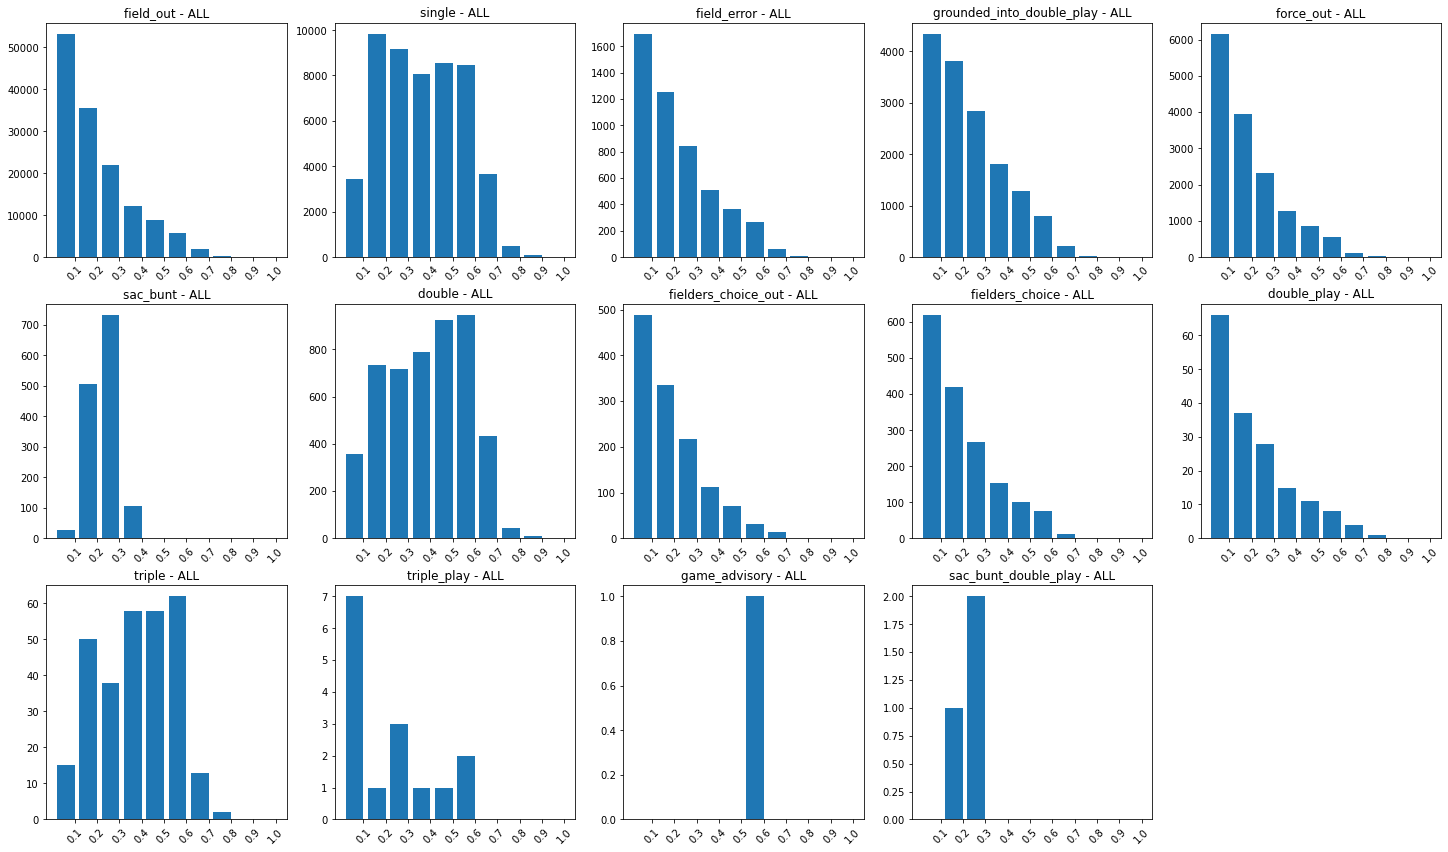

In [12]:
print('ground_ball')
events = plot_against_event(df[df.bb_type == 'ground_ball'], 'estimated_ba_using_speedangle')

line_drive


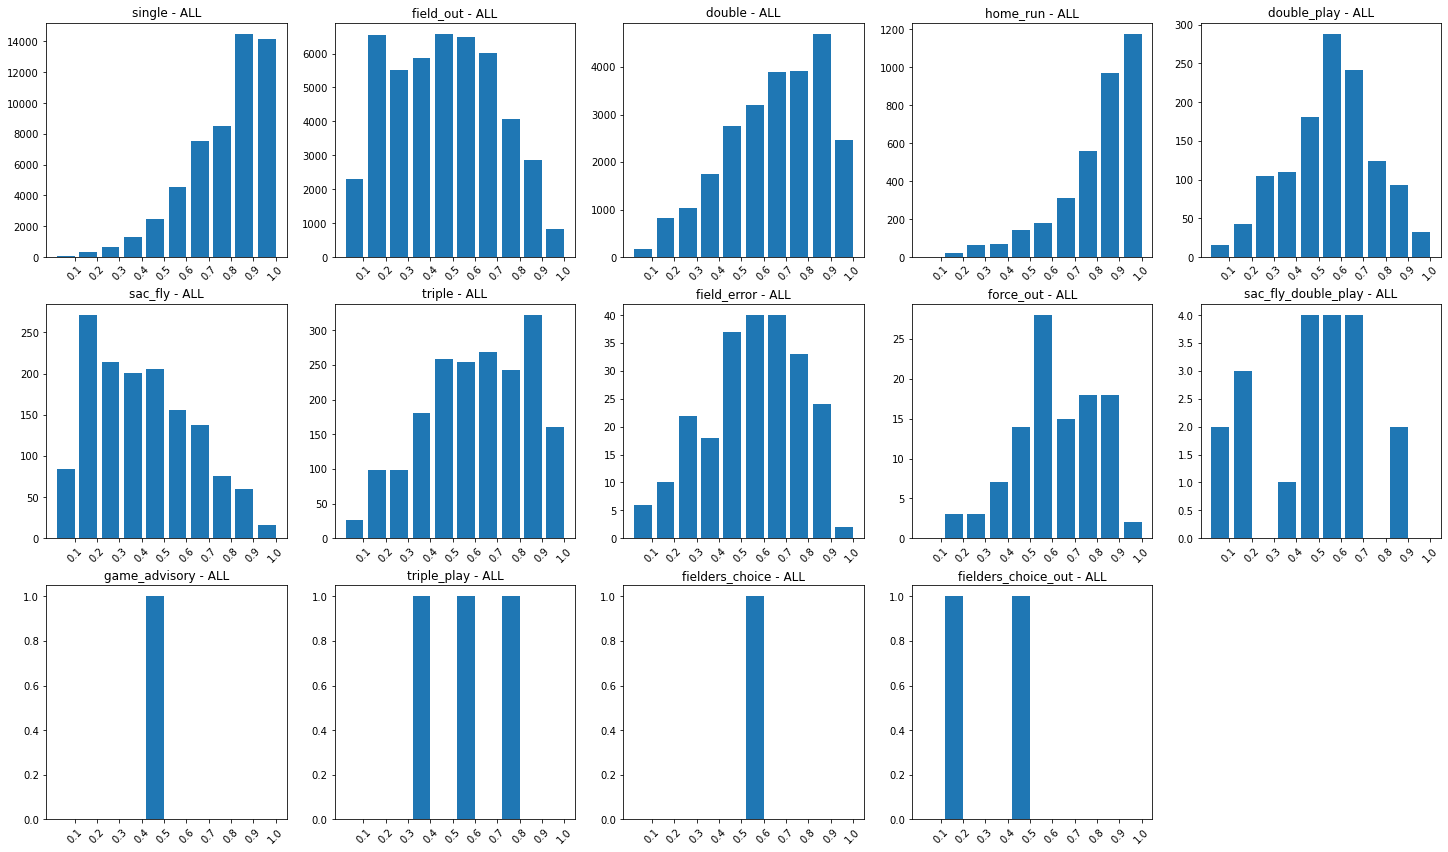

In [13]:
print('line_drive')
events = plot_against_event(df[df.bb_type == 'line_drive'], 'estimated_ba_using_speedangle')

popup


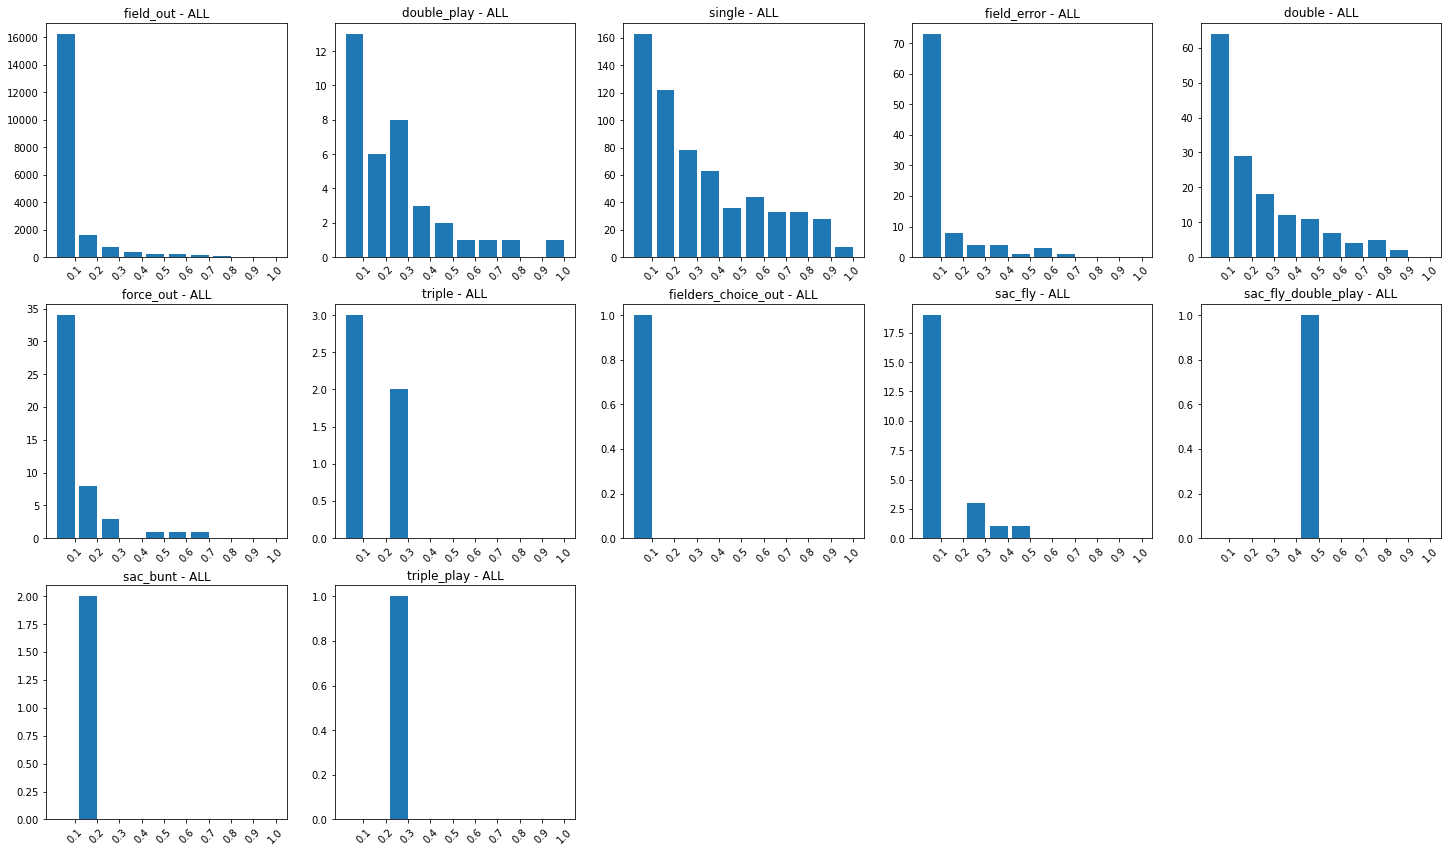

In [14]:
print('popup')
events = plot_against_event(df[df.bb_type == 'popup'], 'estimated_ba_using_speedangle')

fly_ball


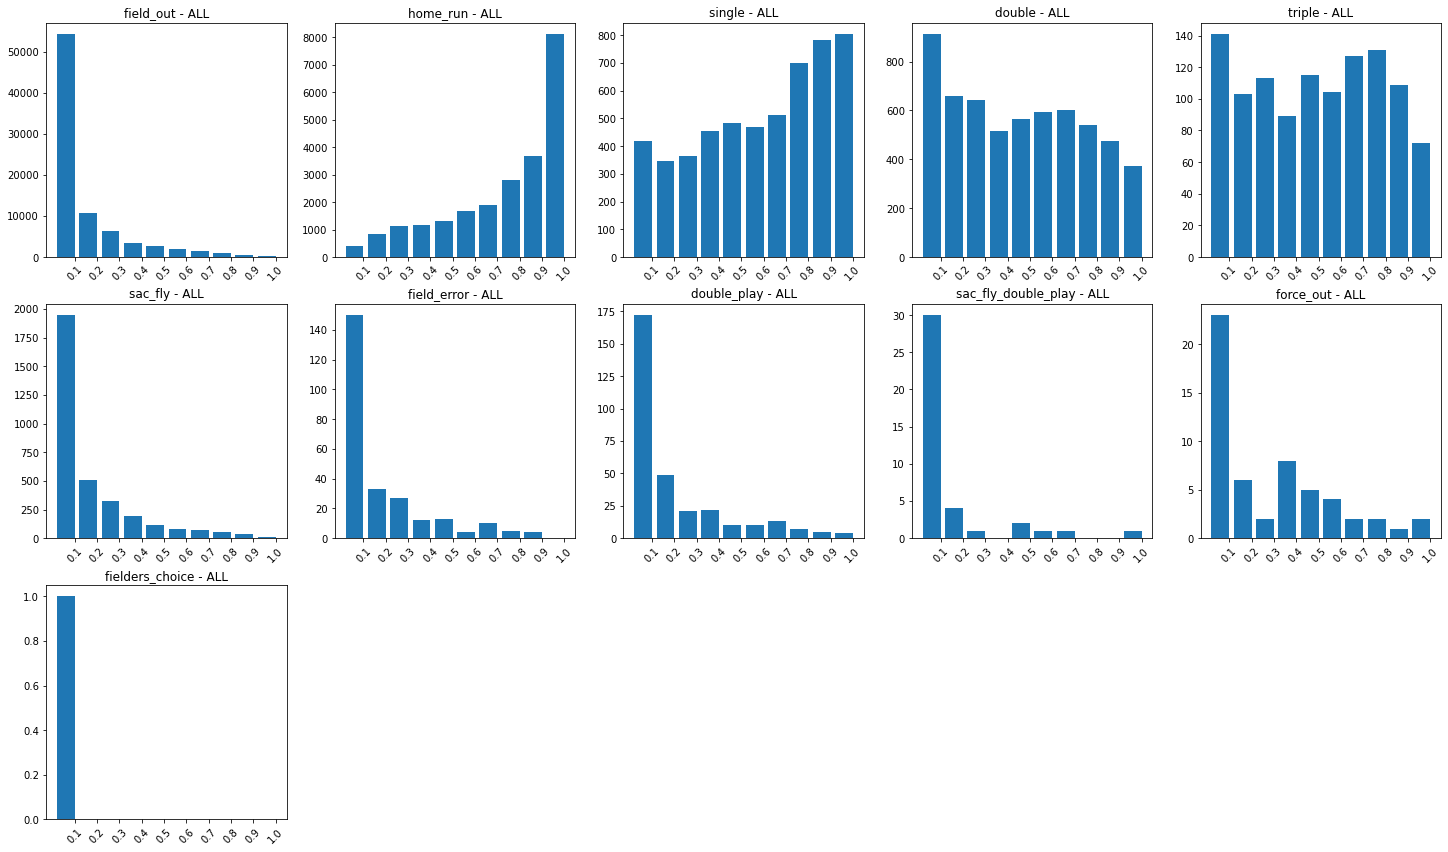

In [15]:
print('fly_ball')
events = plot_against_event(df[df.bb_type == 'fly_ball'], 'estimated_ba_using_speedangle')

A large majority of these values are cleared up and seem to follow a gaussian distribution. Unfortunately, some of these values seem much more random than that. This makes it difficult to fully understand how to handle them. 'bb_type' did help clear things up a bit, so this might be the best way to handle them. For the time being, I will fill these values using the median under the new conditions, but if time allows, I will return to employ some form of multiple imputation.

## Pitch Data Analysis

Before I do any analysis, I want to see how removing events that do not result in a pitch being thrown (i.e. pickoff) might reduce the number of pitches.

In [28]:
no_throw = ['other_out', 'pickoff_1b', 'wild_pitch', 'pickoff_2b', 'pickoff_caught_stealing_3b', 'game_advisory', 'caught_stealing_home', 'pickoff_caught_stealing_home', 'pickoff_caught_stealing_2b', 'pickoff_caught_stealing_2b', 'pitchout', 'swinging_pitchout', 'pickoff_3b', 'foul_pitchout', 'caught_stealing_3b', 'caught_stealing_2b'] 
df_missing_pitch = df.drop(df[df.events.isin(no_throw)].index)

In [29]:
df_missing_pitch[miss_pitch_list].isna().sum()

pitch_type           12720
release_speed        13543
release_pos_x        13817
release_pos_z        13817
zone                 13607
pfx_x                13608
pfx_z                13607
plate_x              13607
plate_z              13607
vx0                  13607
vy0                  13607
vz0                  13607
ax                   13607
ay                   13607
az                   13607
effective_speed      12031
release_spin_rate    55249
release_extension    15046
release_pos_y        13817
pitch_name           12720
spin_axis            17504
dtype: int64

This unfortunately had little impact. The other option I have is setting a minimum pitches to be thrown by a pitcher before accepting their stats. While this might work for training and testing with current data, this data must be present if this model were to be productionized. I simply am hoping much of the missing pitch data is clustered around pitchers who had very few pitches and position players who do not have the statcast systems prepared for them.

In [31]:
df_min_forty = df_missing_pitch.groupby('pitcher').filter(lambda x : len(x)>40)
df_min_forty[miss_pitch_list].isna().sum()

pitch_type           12665
release_speed        13488
release_pos_x        13763
release_pos_z        13763
zone                 13553
pfx_x                13554
pfx_z                13553
plate_x              13553
plate_z              13553
vx0                  13553
vy0                  13553
vz0                  13553
ax                   13553
ay                   13553
az                   13553
effective_speed      12025
release_spin_rate    55180
release_extension    14991
release_pos_y        13763
pitch_name           12665
spin_axis            17448
dtype: int64

In [33]:
df_min_fifty = df_missing_pitch.groupby('pitcher').filter(lambda x : len(x)>50)
df_min_fifty[miss_pitch_list].isna().sum()

pitch_type           12661
release_speed        13484
release_pos_x        13759
release_pos_z        13759
zone                 13549
pfx_x                13550
pfx_z                13549
plate_x              13549
plate_z              13549
vx0                  13549
vy0                  13549
vz0                  13549
ax                   13549
ay                   13549
az                   13549
effective_speed      12025
release_spin_rate    55157
release_extension    14987
release_pos_y        13759
pitch_name           12661
spin_axis            17442
dtype: int64

In [34]:
df_min_hun = df_missing_pitch.groupby('pitcher').filter(lambda x : len(x)>100)
df_min_hun[miss_pitch_list].isna().sum()

pitch_type           12637
release_speed        13461
release_pos_x        13736
release_pos_z        13736
zone                 13526
pfx_x                13527
pfx_z                13526
plate_x              13526
plate_z              13526
vx0                  13526
vy0                  13526
vz0                  13526
ax                   13526
ay                   13526
az                   13526
effective_speed      12017
release_spin_rate    55031
release_extension    14962
release_pos_y        13736
pitch_name           12637
spin_axis            17394
dtype: int64

This also had little impact on the results. While setting a minimum on pitch amount will be used for clustering pitches in some meaningful way, this will have little impact on the missing values. Looking at a few of the rows, we can see that there is diversity in the missing values. In some cases, it is an isolated pitch, while in other cases an entire at-bat or inning is missing the data. This probably signifies a technical fault in recording the data. This is backed up by how rare it is for the missing pitch metrics to be isolated from one another.

In [48]:
pd.options.display.max_columns = None
df[df['pitch_type'].isna()].head(20)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,zone,game_type,stand,p_throws,home_team,away_team,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,fielder_2,vx0,vy0,vz0,ax,ay,az,effective_speed,release_spin_rate,release_extension,game_pk,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,spin_axis,batter_name,pitcher_name,game_month,game_day,bat_event
150,NaN,2017-09-30,90.0,-0.61,6.22,429664,445060,field_out,2.0,R,L,R,LAA,SEA,line_drive,1,0,2017,-0.57,1.44,0.2,3.68,0,0,1,2,3,455117,3.18123278379973,-130.690328979714,-3.26475383143943,-7.17367137477673,27.866686411568,-15.4392271692549,89.4,2026.0,6.0,492512,543068,408252,472528,592743,457708,545361,594777,54.46,0.087,0.182,0.0,1.0,0.0,0.0,20,2,NaN,0,0,0,0,204.0,Robinson Cano,Ricky Nolasco,09,30,field_out
232,NaN,2017-09-30,NaN,NaN,NaN,493596,477569,field_out,NaN,R,R,R,LAA,SEA,fly_ball,0,0,2017,NaN,NaN,NaN,NaN,0,0,0,1,8,455117,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,492512,543068,592230,472528,592743,457708,545361,594777,NaN,NaN,NaN,0.0,NaN,0.0,0.0,67,1,NaN,4,6,6,4,NaN,Gordon Beckham,Fernando Salas,09,30,field_out
252,NaN,2017-09-30,NaN,NaN,NaN,592325,500610,field_out,NaN,R,L,R,LAA,SEA,fly_ball,0,2,2017,NaN,NaN,NaN,NaN,0,0,0,0,9,492802,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,492512,543068,592230,472528,592743,457708,545361,594777,NaN,NaN,NaN,0.0,NaN,0.0,0.0,75,3,NaN,4,6,6,4,NaN,Ben Gamel,Deolis Guerra,09,30,field_out
559,NaN,2017-09-28,93.0,-1.48,6.03,570560,502032,ball,14.0,R,L,R,CWS,LAA,NaN,0,0,2017,-0.92,1.82,1.38,1.34,0,0,0,0,1,542208,9.31062535615928,-134.510690169242,-10.1072323212796,-13.1721122698235,29.8829840839026,-8.121577965138,92.5,2511.0,6.4,492479,543068,592230,472528,460060,519184,458913,453203,54.11,NaN,NaN,NaN,NaN,NaN,NaN,4,1,NaN,0,0,0,0,208.0,Yolmer Sanchez,Bud Norris,09,28,ball
562,NaN,2017-09-28,91.1,-3.33,5.36,541645,622161,ball,11.0,R,R,R,CWS,LAA,NaN,0,0,2017,-1.49,1.15,-0.77,4.11,0,0,0,0,6,542208,9.22904963445342,-131.714923535622,0.467440888645468,-18.7076117269313,29.0674331120985,-19.7056268092615,88.7,2014.0,5.2,492479,543068,592230,472528,460060,519184,458913,453203,55.27,NaN,NaN,NaN,NaN,NaN,NaN,47,1,NaN,2,4,2,4,236.0,Avisail Garcia,Eduardo Paredes,09,28,ball
662,NaN,2017-09-27,NaN,NaN,NaN,541645,433589,ball,NaN,R,R,R,CWS,LAA,NaN,0,2,2017,NaN,NaN,NaN,NaN,0,0,1,1,5,455117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,492465,543068,408252,472528,592743,457708,545361,594777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,3,NaN,3,3,3,3,NaN,Avisail Garcia,Yusmeiro Petit,09,27,ball
1305,NaN,2017-09-22,NaN,NaN,NaN,594828,572070,field_out,NaN,R,R,R,HOU,LAA,line_drive,1,0,2017,NaN,NaN,NaN,NaN,0,0,0,0,3,455117,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,492394,543068,408252,472528,592743,457708,545361,594777,NaN,NaN,NaN,0.0,NaN,0.0,0.0,18,2,NaN,0,0,0,0,NaN,Evan Gattis,Garrett Richards,09,22,field_out
2864,NaN,2017-09-09,NaN,NaN,NaN,628338,644428,ball,NaN,R,R,R,SEA,LAA,NaN,0,0,2017,NaN,NaN,NaN,NaN,0,0,0,2,7,492802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,492221,543068,545337,592230,460060,519184,458913,453203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,NaN,8,0,8,0,NaN,Guillermo Heredia,Troy Scribner,09,09,ball
3615,NaN,2017-09-03,78.9,2.1,5.59,608336,571760,ball,13.0,R,L,L,TEX,LAA,NaN,0,0,2017,-0.1,-0.09,-1.59,2.5,0,0,0,2,3,455117,-7.68255909857704,-114.388613676032,0.2235782788439,0.483235584981739,19.7720299983743,-33.2179016109955,77.7,2435.0,5.5,492139,543068,408252,460060,592743,457708,545361,594777,55.04,NaN,NaN,NaN,NaN,NaN,NaN,27,1,NaN,2,2,2,2,339.0,Joey Gallo,Andrew Heaney,09,03,ball
4834,NaN,2017-08-26,NaN,NaN,NaN,608324,453284,strikeout,NaN,R,R,R,LAA,HOU,NaN,3,2,2017,NaN,NaN,NaN,NaN,0,0,0,2,9,455117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,492027,543068,592230,472528,592743,457727,545361,594777,NaN,NaN,NaN,0.0,

This begs the quesiton of how to handle this data. Due to the limited sample contributing heavily to both models (higher weight of each pitch toward an event) I cannot remove these rows. There is no way to use aggregated functions based on pitch type due to the large amount of overlap between the different missing pitching metrics and descriptors. This leaves two primary options for fillign in this data.

* Fill in missing pitch data with the previously thrown pitch. This is not ideal due to pitchers relying on mixing up their pitches. This leads to most pitches not working in this way. Therefore, this is not an ideal approach.
* Randomly filling in pitches based on thrown percentage of known pitches and their clustered center. This requires a clustering of pitchers' pitches before filling in the data. Then we would take those metrics and randomly assign them by pitch thrown metrics. The only concern here is that pitchers tend to follow a game plan against particular batters based on their weaknesses. However, by incorporating the batters into this multiple imputation, the filling of this data would take too long for the alotted time for this project.

Randomly filling these columns based on pitcher charts appears to be the best solution. Therefore, I will need to cluster the pitches before filling in the missing gaps.

## Discussing Game and At-Bat Consolidation

Ultimately, there is one more concern to consider when discussing missing metrics and future models. This would be how to combine different metrics down to at-bats and full games. Clustering of pitchers will be simply focused around their thrown pitches, and it would make sense to cluster hitters around their performance against these same pitch clusters for matchup comparison. However, this poses a few quesitons:

* Should pitch clusters be focused around 'pitch type' or around the idea that some pitchers have multiple pitches thrown of the same 'tyoe' and/or some pitches that look similar enough to be considered of the same 'type'?
* How do we measure batter performance against these clusters? How do we calculate all pitches thrown in the at-bat? Do we give higher weight to the pitch which resulted in the event?
* Should fuzzy clustering be used to more accurately represent the pitcher repertoire pitch differences?
* How should pitcher metrics be broken down time-wise? Starters tend to pitch once every five days while relievers have a more varied time between appearances. Should we give them both different timelines?
* If pitcher performances are broken down into multiple day segments, should teh same thing be done for batters?

My take on each of these questions are as follows:

* I will try to cluster based on actual pitch types, not the labels attached. I will still use these pitch labels as a base for how many pitch types are being thrown, but I will check for a silhouette score a few pitches on either side of given count.
* I would like to give a higher weight on the pitch that the event is tied to. This would be a hyper-parameter that can be tuned. This would be tied in some way to the number of pitches thrown in the at-bat. Missing pitch data might hinder this, but it should be fine due to the quantity of given data.
* Ideally, I would like to implement fuzzy clustering. This would also impact how some performance might impact certain clusters for the batters. If a pitch cluster is .6 like pitch A and .4 like pitch B, they would contribute that much toward the given cluster. This would increase the amount of desired data for each pitch, but also have some hope for this leading to a better representative model. My main issue is time. There is a possibility that I have to pivot to a simpler clustering system.
* I expect to break down pitchers in the same way, regardless of role. This is due to the difficulty in differentiating pitcher types and pitchers who might change roles midseason (or for certain stretches).
* tters should be given a day-to-day timeline due to the impact of rest days and other performances. If both hitters and pitchers were able to given this timeline, I would have done it, but this is simply not possible.

In [33]:
# estimated_ba_using_speedangle
# estimated_woba_using_speedangle
# woba_denom
# launch_speed_angle
# launch_speed
# launch_angle
# bb_type

In [34]:
# delete sv_id
# handle pitching values
# fix 'game_advisory' in 'events'
# delete launch_speed, launch_angle, launch_speed_angle
# focus on regular season games

In [35]:
# estimated_ba_using_speedangle fill with median
#         ['field_out', 'field_error', 'double', 'grounded_into_double_play', 'home_run', 'force_out', 'sac_bunt', 'sac_fly', 'fielders_choice_out', 'fielders_choice', 'sac_fly_double_play', 'game_advisory', 'sac_bunt_double_play']
#      fill with 
#         ['single', 'double_play', 'triple', 'triple_play']
# estimated_woba_using_speedangle and woba_value fill all with median by year
# woba_denom, babip_value, iso_value fill all with median